# Bitcoin Analysis API

This notebook demonstrates the **API layer** provided by `bitcoin_analysis_utils.py`.  
We’ll load configuration, show how to fetch minute‐ and daily‐level data, and how to initialize/update our PostgreSQL tables programmatically.

**Contents**:
 1. Setup and imports
 2. Fetching minute-level and daily data
 3. Initializing and updating database tables
 4. Loading data from the database
 5. Fitting and forecasting with SARIMAX


##  Install & Imports


In [40]:
! pip install python-dotenv requests pandas sqlalchemy psycopg2-binary statsmodels matplotlib


In [41]:
import os
from dotenv import load_dotenv
from sqlalchemy import inspect, text
import bitcoin_analytics_utils as bau

load_dotenv()

True

# 1.1 Verify Environment

In [42]:
print("API_KEY present:", bool(os.getenv("API_KEY")))
print("DATABASE_URL present:", bool(os.getenv("DATABASE_URL")))

API_KEY present: True
DATABASE_URL present: True


# 2.1 Fetch a single chunk of 10 minutes ending *now*

In [43]:
df_chunk = bau.fetch_minute_data(limit=10)
print(df_chunk.head())

            timestamp  price_usd   volume_usd  volume_btc
0 2025-05-14 05:11:00  103757.29    144107.66       1.389
1 2025-05-14 05:12:00  103721.06  29097905.25     280.540
2 2025-05-14 05:13:00  103760.37    314127.81       3.028
3 2025-05-14 05:14:00  103750.40    193415.40       1.864
4 2025-05-14 05:15:00  103765.12    185006.06       1.783


# 2.2 Backfill the last N days (configured in utils)

In [44]:
df_hist = bau.fetch_full_historical_minutes()
print(f"Backfilled {len(df_hist)} rows from the past {bau.HISTORICAL_DAYS} days")

Backfilled 2882 rows from the past 2 days


# 3.1 Ensure table exists (will backfill if missing)

In [45]:
bau.ensure_minute_table()

# 3.2 Append any new bars (and prune old rows)

In [46]:
bau.update_minute_table()

# 4.1 Fetch a single daily bar (most recent close)

In [47]:
df_day = bau.fetch_daily_data(limit=1)
print(df_day)

         date   open_usd   high_usd    low_usd  close_usd    volume_usd
0  2025-05-13  102802.44  105015.14  101466.16  104136.59  2.105889e+09
1  2025-05-14  104136.59  104142.05  103458.96  103787.48  2.802446e+08


# 4.2 Backfill a custom number of days (e.g. 30)

In [48]:
df_30 = bau.fetch_full_historical_days(total_days=30)
print(f"Backfilled {len(df_30)} days of history")

Backfilled 30 days of history


# 5.1 Ensure daily table exists (will default to 365 days backfill)

In [49]:
bau.ensure_daily_table()


# 5.2 Append the latest daily bar if it’s new

In [50]:
bau.update_daily_table()

# 6.1 Load daily close series from DB

In [51]:
series = bau.load_daily_from_db()
print(f"Loaded {len(series)} daily closing prices")

Loaded 1828 daily closing prices


# 6.2 Fit an ARIMA(1,1,1)

In [52]:
res = bau.fit_sarimax(series, order=(1,1,1))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


# 6.3 Produce a 14‑day forecast

In [53]:
fc_df = bau.forecast_sarimax(res, steps=14)
print(fc_df[['mean', 'mean_ci_lower', 'mean_ci_upper']].head())

close_usd            mean  mean_ci_lower  mean_ci_upper
2025-05-15  103757.550144  100871.558948  106643.541339
2025-05-16  103750.560109   99793.561792  107707.558425
2025-05-17  103752.380538   98931.486945  108573.274131
2025-05-18  103751.906440   98205.957307  109297.855573
2025-05-19  103752.029910   97564.024086  109940.035735


### Plotting

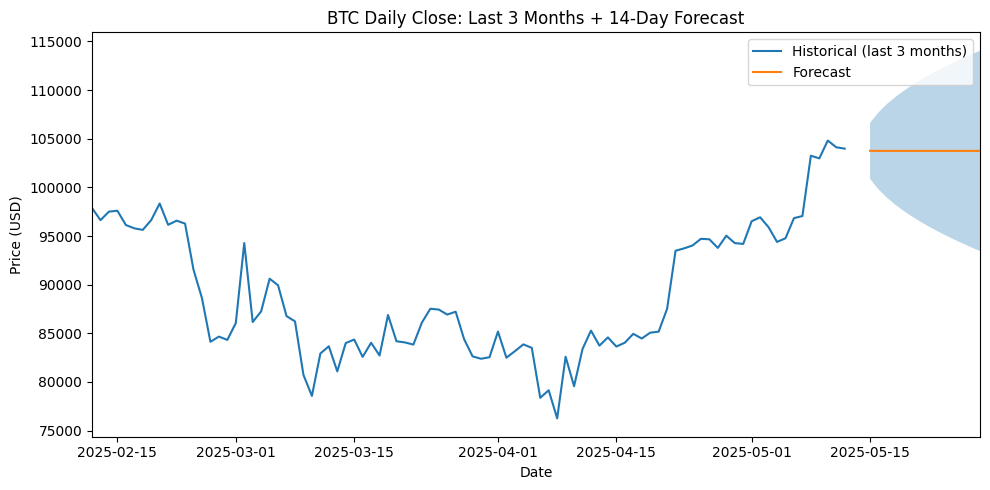

In [57]:
# compute the six-month window
last_historical_date = close_series.index.max()
start_date = last_historical_date - pd.DateOffset(months=3)

# plot zoomed view
plt.figure(figsize=(10, 5))
plt.plot(close_series[start_date:], label='Historical (last 3 months)')
plt.plot(fc_df['mean'], label='Forecast')
plt.fill_between(
    fc_df.index,
    fc_df['mean_ci_lower'],
    fc_df['mean_ci_upper'],
    alpha=0.3
)
plt.xlim(start_date, fc_df.index.max())
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('BTC Daily Close: Last 3 Months + 14-Day Forecast')
plt.tight_layout()
plt.show()